# Classificador de imagens multiclasse - Aposentos de uma casa

**Contexto:** Temos um conjunto de imagens que representam 5 categorias de partes de uma casa: banheiro, quarto, sala de jantar, cozinha e sala de estar. O objetivo deste notebook é criar um modelo de visão computacional que consiga classificar uma imagem dentre essas categorias. 

**Estrutura:** O notebook está dividido assim:

1. Importação das bibliotecas
2. Acesso e tratamento dos dados que serão a entrada do modelo de deep learning
3. Configuração do modelo de deep learning usando uma rede neural convolucional (CNN) simples com Keras
4. Treinamento do modelo de deep learning
5. Execução do modelo de deep learning treinado
6. Avaliação do modelo de deep learning
7. Exportação do modelo de deep learning
8. Teste do modelo exportado

**Créditos:** O notebook foi desenvolvido e documentado pelos professores:

- Hugo Villamizar
- Patrick Happ

**Dataset:** O dataset foi baixado do Kaggle, uma plataforma online voltada para cientistas de dados, entusiastas de aprendizado de máquina e profissionais afins. O uso é estritamente didático. Para mais informações sobre o dataset, veja o link a seguir: [House data kaggle](https://www.kaggle.com/datasets/mikhailma/house-rooms-streets-image-dataset).

## 1. Importando as bibliotecas necessárias para executar o notebook

P.S. Para conseguir executar o notebook terá que instalar bibliotecas como Tensorflow, keras, scikit-learn. Por exemplo:

`pip install tensorflow`

`pip install keras`

`pip install pandas`

`pip install scikit-learn`

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn.metrics as skm
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from IPython.display import Image, display
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import numpy as np
import matplotlib.pyplot as plt

#### Utilidades

`plot_confusion_matrix` é uma função python que imprime uma matriz de confusão

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta função imprime e plota a matriz de confusão.
    A normalização pode ser aplicada definindo `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão sem normalização')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Label real')
    plt.xlabel('Label predito')

## 2. Acessando e tratando os dados que serão a entrada do modelo de deep learning

#### Definação dos caminhos para os dados de treinamento e teste

In [3]:
train_dir = 'datasets/house/train'
val_dir = 'datasets/house/val'
test_dir = 'datasets/house/test'

#### Definação do tamanho do batch e as dimensões das imagens

In [4]:
batch_size = 32
img_height = 224
img_width = 224
num_classes = 5

#### Preparação dos dados
`ImageDataGenerator` é uma classe utilitária fornecida pelo TensorFlow para aumentar e pré-processar dados de imagens. É comumente usada em tarefas de deep learning, especialmente para classificação de imagens, para gerar imagens aumentadas (data augmentation) sob demanda durante o treinamento do modelo. 

Veja que neste caso é usado o método `flow_from_directory()` para gerar imagens aumentadas a partir de um diretório contendo as imagens originais. O método recebe parâmetros como o diretório com as imagens, o tamanho final da imagem, o tamanho do lote (batch size) e o modo de classe (neste caso, categóricas porque são várias classes), entre outros.

Importante ressaltar que o pré-processamento de validação e teste não evolve o aumento de dados.

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Criação dos data generators
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical') #training set

val_generator = test_datagen.flow_from_directory(val_dir,
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical')

Found 200 images belonging to 5 classes.
Found 5 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


## 3. Configuração de um modelo de deep learning usando uma rede neural convolucional (CNN) simples com a biblioteca Keras

#### Definição do arquitetura do modelo. 

Aqui é especificada uma `camada convolucional 2D` que possui 32 filtros e usa a função de ativação `ReLU`. O parâmetro `input_shape` define a forma das imagens de entrada para a rede. Na sequência é adicionada uma camada `softmax` com a mesma função de ativação.  

In [6]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height,img_width,3)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

## 4. Treinamento do modelo de deep learning

#### Compilação do modelo Keras com as configurações do treinamento. 

`optimizer='adam'`: especifica o otimizador a ser usado durante o treinamento.

`loss='categorical_crossentropy'`: especifica a função de perda a ser usada durante o treinamento. Para problemas de classificação multiclasse, onde a variável alvo tem mais de duas categorias, a perda categórica de entropia cruzada é freqüentemente empregada.

`metrics=['accuracy']`: especifica as métricas de avaliação a serem usadas durante o treinamento e o teste.

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

`epochs = 20` define o número de épocas de treinamento para o modelo. Uma época representa uma passagem completa por todo o conjunto de dados de treinamento.

Já o método `fit()` inicia o processo de treinamento do modelo usando o número especificado de épocas. 

In [8]:
epochs = 20
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

Train for 7 steps, validate for 1 steps
Epoch 1/20
7/7 [==============================] - 10s 1s/step - loss: 3.1558 - accuracy: 0.2250 - val_loss: 1.6193 - val_accuracy: 0.2000
Epoch 2/20
7/7 [==============================] - 9s 1s/step - loss: 1.6153 - accuracy: 0.2150 - val_loss: 1.6292 - val_accuracy: 0.2000
Epoch 3/20
7/7 [==============================] - 8s 1s/step - loss: 1.6323 - accuracy: 0.1950 - val_loss: 1.6071 - val_accuracy: 0.2000
Epoch 4/20
7/7 [==============================] - 8s 1s/step - loss: 1.6057 - accuracy: 0.2200 - val_loss: 1.5912 - val_accuracy: 0.2000
Epoch 5/20
7/7 [==============================] - 8s 1s/step - loss: 1.6076 - accuracy: 0.2550 - val_loss: 1.5519 - val_accuracy: 0.6000
Epoch 6/20
7/7 [==============================] - 8s 1s/step - loss: 1.5789 - accuracy: 0.2550 - val_loss: 1.4351 - val_accuracy: 0.4000
Epoch 7/20
7/7 [==============================] - 8s 1s/step - loss: 1.5303 - accuracy: 0.3450 - val_loss: 1.3511 - val_accuracy: 0.6000


## 5. Execução do modelo de deep learning treinado em cada uma das imagens de teste

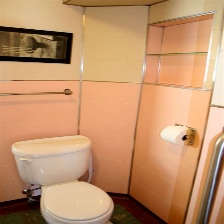

Label: bath
Previsão: kitchen
Probabilidade: 0.7261298




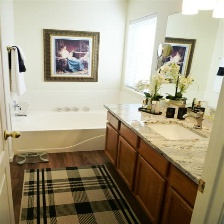

Label: bath
Previsão: living
Probabilidade: 0.76160645




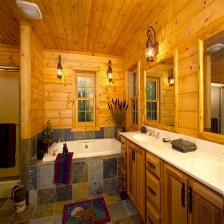

Label: bath
Previsão: living
Probabilidade: 0.7040936




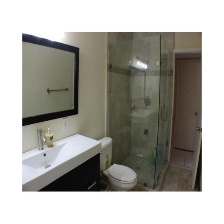

Label: bath
Previsão: bed
Probabilidade: 0.96569556




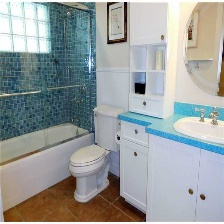

Label: bath
Previsão: bed
Probabilidade: 0.76238805




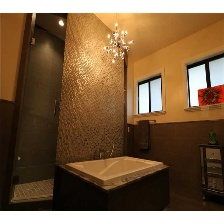

Label: bath
Previsão: bed
Probabilidade: 0.9853898




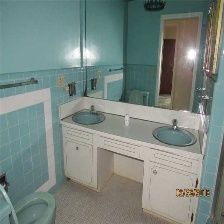

Label: bath
Previsão: kitchen
Probabilidade: 0.33778796




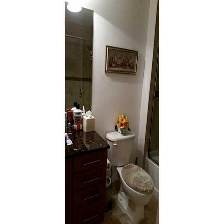

Label: bath
Previsão: living
Probabilidade: 0.79124147




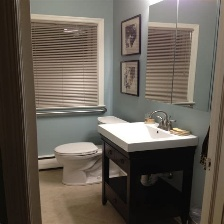

Label: bath
Previsão: living
Probabilidade: 0.8203187




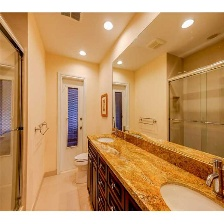

Label: bath
Previsão: kitchen
Probabilidade: 0.47282144




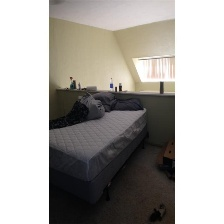

Label: bed
Previsão: bed
Probabilidade: 0.75911045




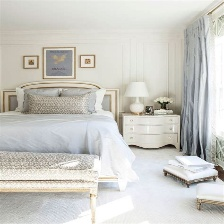

Label: bed
Previsão: living
Probabilidade: 0.38525024




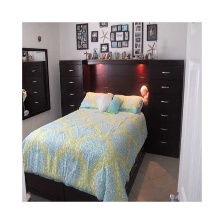

Label: bed
Previsão: bed
Probabilidade: 0.9286669




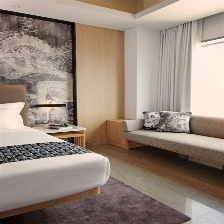

Label: bed
Previsão: living
Probabilidade: 0.90396833




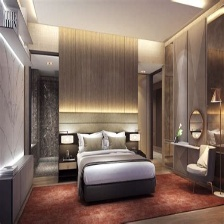

Label: bed
Previsão: living
Probabilidade: 0.80595607




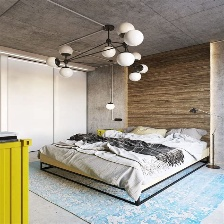

Label: bed
Previsão: din
Probabilidade: 0.66807973




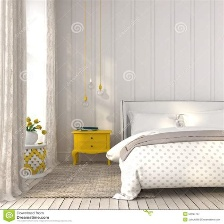

Label: bed
Previsão: living
Probabilidade: 0.43112525




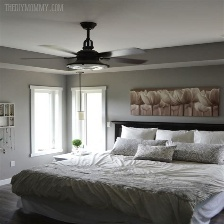

Label: bed
Previsão: living
Probabilidade: 0.5713484




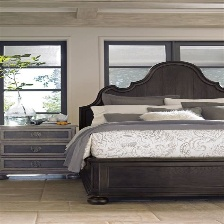

Label: bed
Previsão: din
Probabilidade: 0.82042843




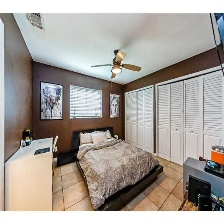

Label: bed
Previsão: kitchen
Probabilidade: 0.94422597




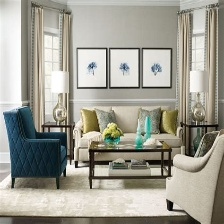

Label: living
Previsão: din
Probabilidade: 0.8132508




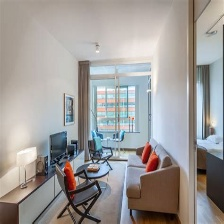

Label: living
Previsão: living
Probabilidade: 0.48609403




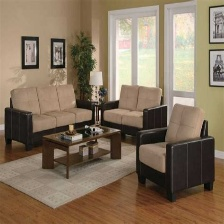

Label: living
Previsão: living
Probabilidade: 0.8586396




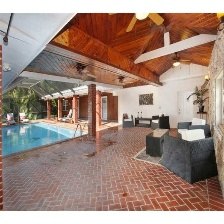

Label: living
Previsão: kitchen
Probabilidade: 0.7121909




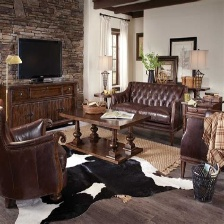

Label: living
Previsão: din
Probabilidade: 0.9361477




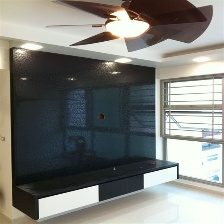

Label: living
Previsão: bath
Probabilidade: 0.6121357




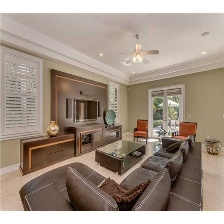

Label: living
Previsão: din
Probabilidade: 0.6779785




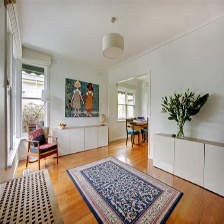

Label: living
Previsão: living
Probabilidade: 0.58106965




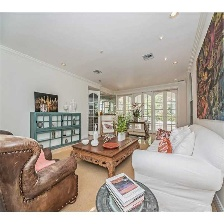

Label: living
Previsão: din
Probabilidade: 0.8964233




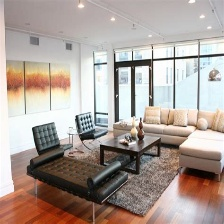

Label: living
Previsão: living
Probabilidade: 0.6934516




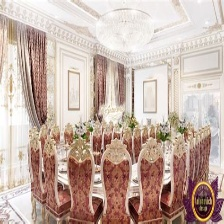

Label: din
Previsão: din
Probabilidade: 0.98636174




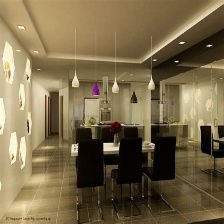

Label: din
Previsão: living
Probabilidade: 0.9459838




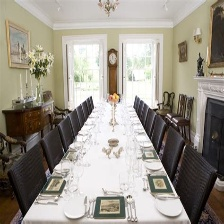

Label: din
Previsão: din
Probabilidade: 0.50577873




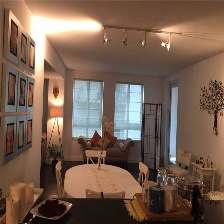

Label: din
Previsão: din
Probabilidade: 0.8457418




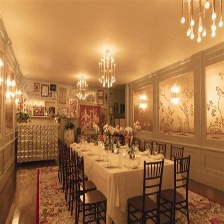

Label: din
Previsão: din
Probabilidade: 0.57765913




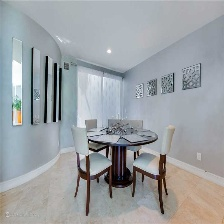

Label: din
Previsão: din
Probabilidade: 0.977155




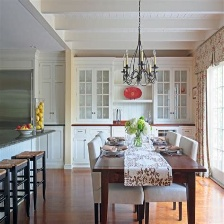

Label: din
Previsão: kitchen
Probabilidade: 0.7007979




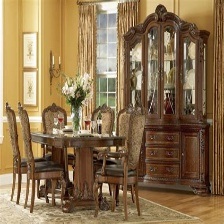

Label: din
Previsão: din
Probabilidade: 0.8512925




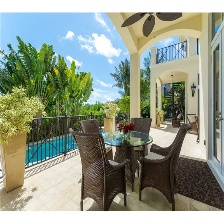

Label: din
Previsão: din
Probabilidade: 0.95613974




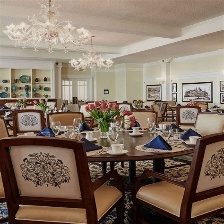

Label: din
Previsão: din
Probabilidade: 0.99440926




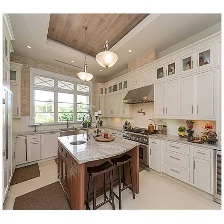

Label: kitchen
Previsão: din
Probabilidade: 0.8807215




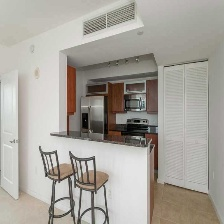

Label: kitchen
Previsão: din
Probabilidade: 0.44548813




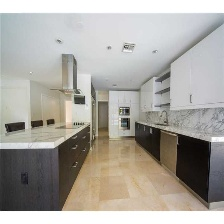

Label: kitchen
Previsão: living
Probabilidade: 0.51469576




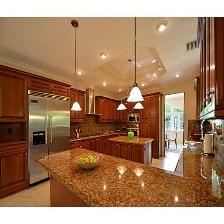

Label: kitchen
Previsão: din
Probabilidade: 0.49356657




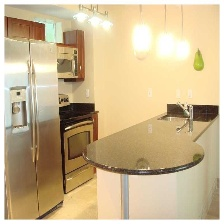

Label: kitchen
Previsão: din
Probabilidade: 0.6208238




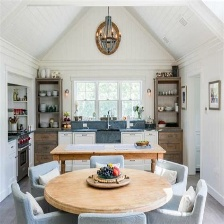

Label: kitchen
Previsão: din
Probabilidade: 0.82667464




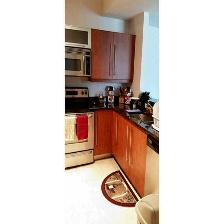

Label: kitchen
Previsão: living
Probabilidade: 0.93758696




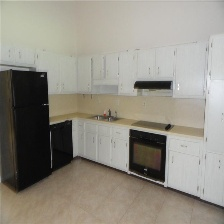

Label: kitchen
Previsão: kitchen
Probabilidade: 0.8210876




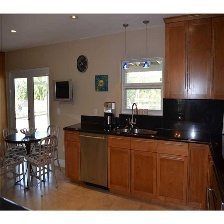

Label: kitchen
Previsão: kitchen
Probabilidade: 0.92525226




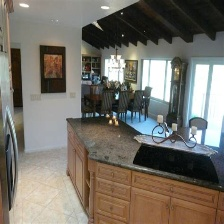

Label: kitchen
Previsão: kitchen
Probabilidade: 0.6411102




In [9]:
parent_dir = 'datasets/house/test'
count_images = 0
class_names = ['bath', 
               'bed', 
               'din', 
               'kitchen', 
               'living']
y_pred = list()
y_true = list()

# Percorrendo a pasta onde estão salvas as imagens de teste
for subdir, dirs, files in os.walk(parent_dir):
    
    for file in files:
        
        if file.endswith('.png') or file.endswith('.jpg'):
            
            count_images+=1
            split_path = os.path.join(subdir, file).split('/')
            label = split_path[3]
            y_true.append(label)
            
            img_path = os.path.join(subdir, file)
            display(Image(filename=img_path, width=300))
            
            img = image.load_img(img_path, target_size=(img_height, img_width))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = x.astype('float32') / 255.0

            # Previsão
            prediction = model.predict(x)

            # Printando as saídas do modelo           
            predicted_class = np.argmax(prediction[0])
            probability = prediction[0][predicted_class]
            y_pred.append(class_names[predicted_class])
            print("Label:", label)
            print("Previsão:", class_names[predicted_class])
            print("Probabilidade:", probability)
            print("\n")

#### Visualização de métricas da avaliação do modelo

In [10]:
# Calculando as métricas
accuracy = skm.accuracy_score(y_true, y_pred)
precision = skm.precision_score(y_true, y_pred, average='weighted')
recall = skm.recall_score(y_true, y_pred, average='weighted')
f1score = skm.f1_score(y_true, y_pred, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1score)

Accuracy:  0.34
Precision:  0.2808771929824561
Recall:  0.34
F1 Score:  0.28837451719484386


Matriz de confusão para identificar onde o modelo de deep learning acertou e errou na classificação das imagens de teste

Matriz de confusão sem normalização


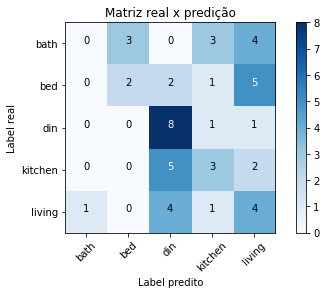

In [11]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes=['bath', 
                               'bed', 
                               'din', 
                               'kitchen', 
                               'living'],
                      normalize= False, 
                      title='Matriz real x predição')

## 7. Exportação do modelo de deep learning para posterior uso

Salvando o modelo de deep learning que foi treinado

In [12]:
# obtendo a data e hora atual
now = datetime.now()

# Definição do formato
format = '%Y-%m-%dT%H%M'

# Converter a data e hora em uma string com o formato especificado
formatted_datetime = now.strftime(format)

path_model = 'datasets/house/trained_models'

name_model = 'trained_model_' + formatted_datetime + '.h5'

# salvando o modelo
model.save("%s/%s" % (path_model, name_model))
print("Modelo salvo com o nome: ", name_model)

Modelo salvo com o nome:  trained_model_2023-06-19T1600.h5


## 8. Teste do modelo exportado

Carregando o modelo salvo

In [13]:
loaded_model = keras.models.load_model("%s/%s" % (path_model, name_model))
print("Modelo %s carregado com sucesso" % (name_model))

Modelo trained_model_2023-06-19T1600.h5 carregado com sucesso


Executando o modelo exportado para acompanhar as classificações de cada uma das imagens de teste

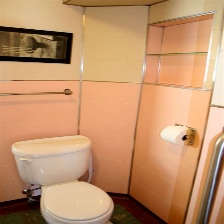

Label: bath
Previsão: kitchen
Probabilidade: 0.7261298




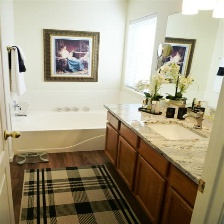

Label: bath
Previsão: living
Probabilidade: 0.76160645




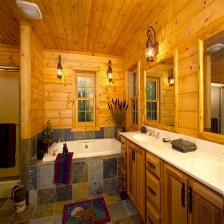

Label: bath
Previsão: living
Probabilidade: 0.7040936




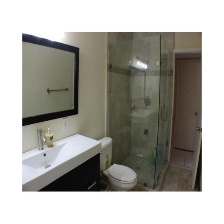

Label: bath
Previsão: bed
Probabilidade: 0.96569556




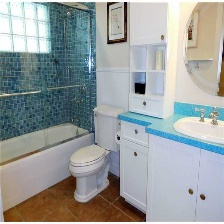

Label: bath
Previsão: bed
Probabilidade: 0.76238805




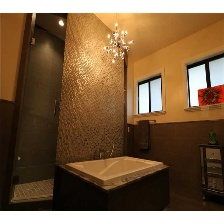

Label: bath
Previsão: bed
Probabilidade: 0.9853898




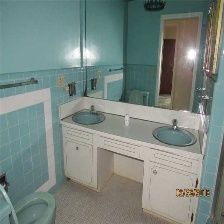

Label: bath
Previsão: kitchen
Probabilidade: 0.33778796




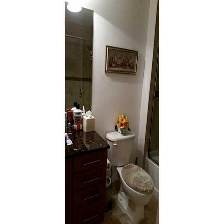

Label: bath
Previsão: living
Probabilidade: 0.79124147




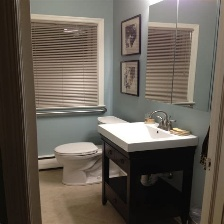

Label: bath
Previsão: living
Probabilidade: 0.8203187




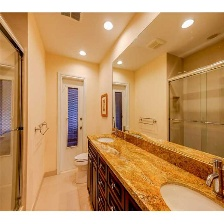

Label: bath
Previsão: kitchen
Probabilidade: 0.47282144




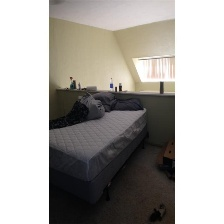

Label: bed
Previsão: bed
Probabilidade: 0.75911045




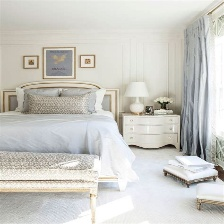

Label: bed
Previsão: living
Probabilidade: 0.38525024




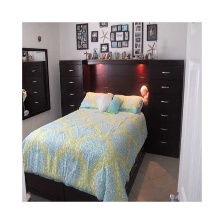

Label: bed
Previsão: bed
Probabilidade: 0.9286669




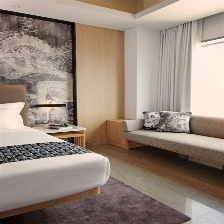

Label: bed
Previsão: living
Probabilidade: 0.90396833




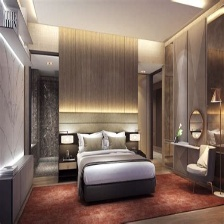

Label: bed
Previsão: living
Probabilidade: 0.80595607




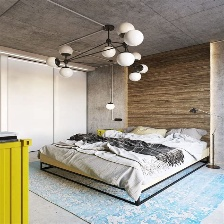

Label: bed
Previsão: din
Probabilidade: 0.66807973




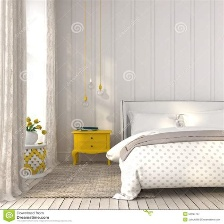

Label: bed
Previsão: living
Probabilidade: 0.43112525




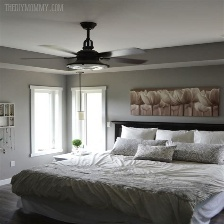

Label: bed
Previsão: living
Probabilidade: 0.5713484




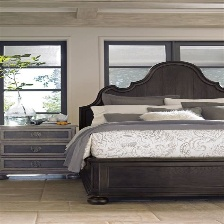

Label: bed
Previsão: din
Probabilidade: 0.82042843




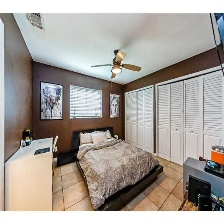

Label: bed
Previsão: kitchen
Probabilidade: 0.94422597




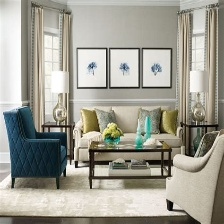

Label: living
Previsão: din
Probabilidade: 0.8132508




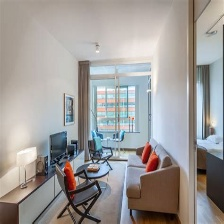

Label: living
Previsão: living
Probabilidade: 0.48609403




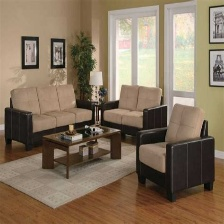

Label: living
Previsão: living
Probabilidade: 0.8586396




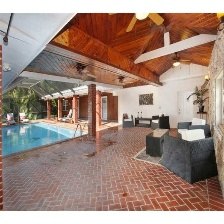

Label: living
Previsão: kitchen
Probabilidade: 0.7121909




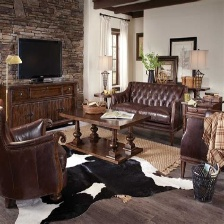

Label: living
Previsão: din
Probabilidade: 0.9361477




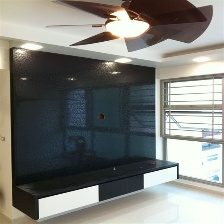

Label: living
Previsão: bath
Probabilidade: 0.6121357




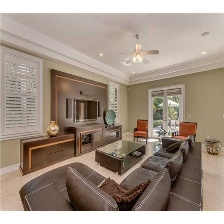

Label: living
Previsão: din
Probabilidade: 0.6779785




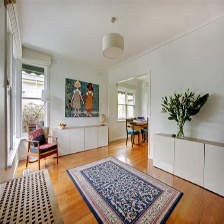

Label: living
Previsão: living
Probabilidade: 0.58106965




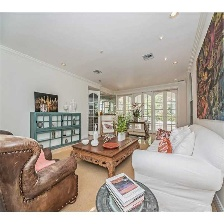

Label: living
Previsão: din
Probabilidade: 0.8964233




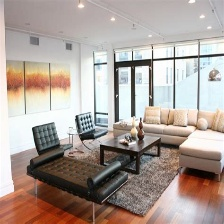

Label: living
Previsão: living
Probabilidade: 0.6934516




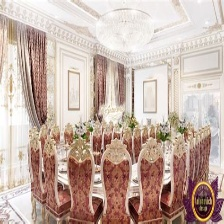

Label: din
Previsão: din
Probabilidade: 0.98636174




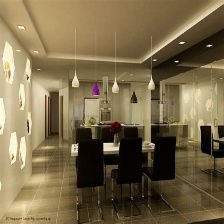

Label: din
Previsão: living
Probabilidade: 0.9459838




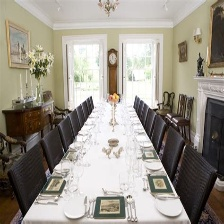

Label: din
Previsão: din
Probabilidade: 0.50577873




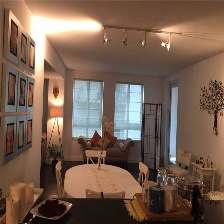

Label: din
Previsão: din
Probabilidade: 0.8457418




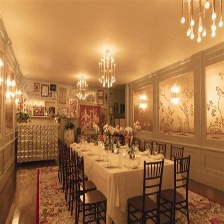

Label: din
Previsão: din
Probabilidade: 0.57765913




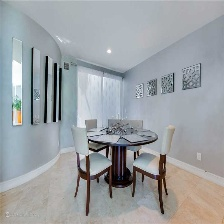

Label: din
Previsão: din
Probabilidade: 0.977155




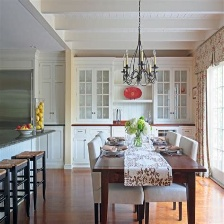

Label: din
Previsão: kitchen
Probabilidade: 0.7007979




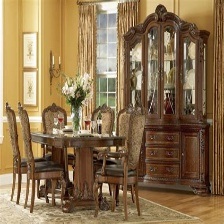

Label: din
Previsão: din
Probabilidade: 0.8512925




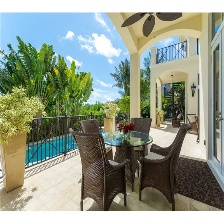

Label: din
Previsão: din
Probabilidade: 0.95613974




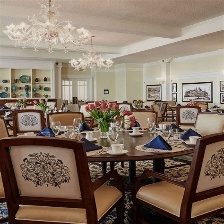

Label: din
Previsão: din
Probabilidade: 0.99440926




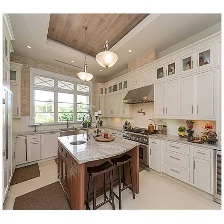

Label: kitchen
Previsão: din
Probabilidade: 0.8807215




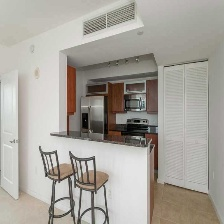

Label: kitchen
Previsão: din
Probabilidade: 0.44548813




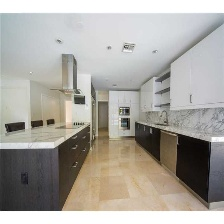

Label: kitchen
Previsão: living
Probabilidade: 0.51469576




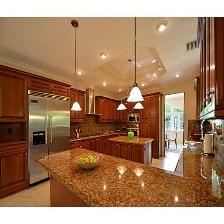

Label: kitchen
Previsão: din
Probabilidade: 0.49356657




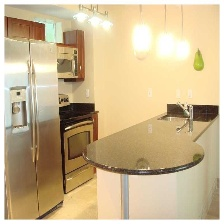

Label: kitchen
Previsão: din
Probabilidade: 0.6208238




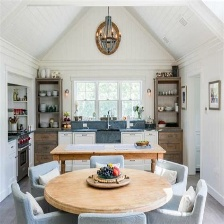

Label: kitchen
Previsão: din
Probabilidade: 0.82667464




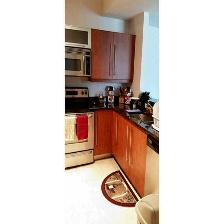

Label: kitchen
Previsão: living
Probabilidade: 0.93758696




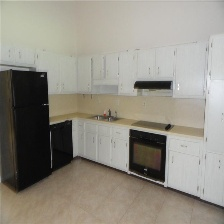

Label: kitchen
Previsão: kitchen
Probabilidade: 0.8210876




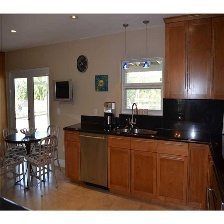

Label: kitchen
Previsão: kitchen
Probabilidade: 0.92525226




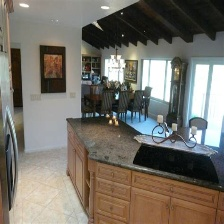

Label: kitchen
Previsão: kitchen
Probabilidade: 0.6411102




In [14]:
parent_dir = 'datasets/house/test'
count_images = 0
class_names = ['bath', 
               'bed', 
               'din', 
               'kitchen', 
               'living']
y_pred = list()
y_true = list()

# Percorrendo a pasta onde estão salvas as imagens de teste
for subdir, dirs, files in os.walk(parent_dir):
    
    for file in files:
        
        if file.endswith('.png') or file.endswith('.jpg'):
            
            count_images+=1
            split_path = os.path.join(subdir, file).split('/')
            label = split_path[3]
            y_true.append(label)
            
            img_path = os.path.join(subdir, file)
            display(Image(filename=img_path, width=300))
            
            img = image.load_img(img_path, target_size=(img_height,img_width))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = x.astype('float32') / 255.0

            # Previsão
            prediction = loaded_model.predict(x)

            # Printando as saídas do modelo            
            predicted_class = np.argmax(prediction[0])
            probability = prediction[0][predicted_class]
            y_pred.append(class_names[predicted_class])
            print("Label:", label)
            print("Previsão:", class_names[predicted_class])
            print("Probabilidade:", probability)
            print("\n")